# TP Module 7 : Les modèles générateurs



In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D


print(tf.__version__)
print(keras.__version__)

import random
import os
import numpy as np

# freeze de l'aléatoire, pour avoir des expériences reproductibles.
RANDOM_SEED = 42

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

2.2.0
2.3.0-tf


In [0]:
!nvidia-smi

Thu May 28 12:31:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import Data

In [0]:
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
cifar = np.concatenate([x_train, x_test], axis=0)
cifar = (cifar.astype("float32")-127.5)/ 127.5
cifar.shape

(60000, 32, 32, 3)

In [0]:
ds = tf.data.Dataset.from_tensor_slices(cifar)
ds = ds.shuffle(buffer_size=60000)
ds = ds.batch(256)
ds = ds.prefetch(1)

In [0]:
for item in ds.take(1):
  print(item.shape)

(256, 32, 32, 3)


In [0]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2020-05-27 18:11:41--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.41
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  16.5MB/s    in 86s     

2020-05-27 18:13:08 (16.0 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [0]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")
print('Done')

In [0]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))
img_list.sort()
random.shuffle(img_list)
img_list[0]

202599


'020294.jpg'

In [0]:
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 64])
    return image

In [0]:
import pathlib
ds = tf.data.Dataset.list_files(str(pathlib.Path(root)/'*.*'), seed=RANDOM_SEED)
ds = ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(256)
ds = ds.prefetch(1)

In [0]:
for item in ds.take(1):
  print(item.shape)

(256, 64, 64, 3)


## VAE

### Blocs de base

In [0]:
def conv_bn_relu(tensor, filters, kernel_size, strides):

  x = Conv2D(filters,
             kernel_size,
             strides,
             padding='same',
             kernel_initializer='he_normal')(tensor)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  return x

def conv_bn_lrelu(tensor, filters, kernel_size, strides):

  x = Conv2D(filters,
             kernel_size,
             strides,
             padding='same',
             kernel_initializer='he_normal')(tensor)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  return x

def convT_bn_relu(tensor, filters, kernel_size, strides):

  x = Conv2DTranspose(filters,
                      kernel_size,
                      strides,
                      padding='same',
                      kernel_initializer='he_normal')(tensor)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  return x

### Encodeur

In [0]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

$$\begin{aligned}
\mathbf{z} &\sim q_\phi(\mathbf{z}\vert\mathbf{x}^{(i)}) = \mathcal{N}(\mathbf{z}; \boldsymbol{\mu}^{(i)}, \boldsymbol{\sigma}^{2(i)}\boldsymbol{I}) & \\
\mathbf{z} &= \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon} \text{, where } \boldsymbol{\epsilon} \sim \mathcal{N}(0, \boldsymbol{I}) & \scriptstyle{\text{ Astuce de Reparamétrisation.}}
\end{aligned}$$

In [0]:
latent_dim = 32
dim = 64
encoder_inputs = Input(shape=(64, 64, 3))
# partie conv2d pour extraire les features, le strides de 2 permet de réduire la taille des features maps sans faire appel au pooling, qui n'est pas
#disponible dans la partie decodeur.


x = conv_bn_relu(encoder_inputs, dim, 4, 2)
x = conv_bn_relu(x, dim * 2, 4, 2)
x = conv_bn_relu(x, dim * 4, 4, 2)
x = conv_bn_relu(x, dim * 8, 4, 2)

#sortie de la partie convolutive vers l'espace latent
x = Flatten()(x)
x = Dense(256, activation="relu")(x)

#calu de mu et log_var
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

#ehcnatillonage de z dans l'espace latent
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 64)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

### Décodeur

In [0]:
latent_inputs = keras.Input(shape=(latent_dim,))


x = Dense(4 * 4 * 512, activation="relu")(latent_inputs)
x = Reshape((4, 4, 512))(x)

x = convT_bn_relu(x, dim*8, 4, 2)
x = convT_bn_relu(x, dim*4, 4, 2)
x = convT_bn_relu(x, dim*2, 4, 2)
x = convT_bn_relu(x, dim*1, 4, 2)

# l'activation sigmoide est ici pour avoir des pixels à valeur dans l'intervalle [0,1], comme une image RGB normalisée
decoder_outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              270336    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         4194816   
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       2097

### Custom Class

In [0]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        #print(type(data))
        #data = data[0]
        #print(data.numpy().shape)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 32*32
            
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            
            beta_kl_loss = self.beta*kl_loss

            total_loss = reconstruction_loss + beta_kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss" : total_loss,
            "reconstruction_loss" : reconstruction_loss,
            "kl_loss" : kl_loss,
            "beta_kl" : beta_kl_loss,
        }
      
    def call(self, input):
      x = self.encoder(input)
      x = self.decoder(x)

      return x


```python
def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
```
```python
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 32 * 32
```
$$- \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z})$$

```python
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
```
$$D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x})\|p_\theta(\mathbf{z}))$$
```python
            beta_kl_loss = beta*kl_loss
```
$$\beta D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x})\|p_\theta(\mathbf{z}))$$
```python
            total_loss = reconstruction_loss + beta_kl_loss
```
$$L_\text{BETAVAE}(\phi, \beta) = - \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z}\vert\mathbf{x})} \log p_\theta(\mathbf{x}\vert\mathbf{z}) + \beta D_\text{KL}(q_\phi(\mathbf{z}\vert\mathbf{x})\|p_\theta(\mathbf{z}))$$

In [0]:
vae = VAE(encoder, decoder, 4)
vae.compile(optimizer=keras.optimizers.Adam(0.0001))

In [0]:
vae.fit(ds,
        epochs=20)

Epoch 1/20
792/792 [==============================] - 384s 485ms/step - loss: 574.6848 - reconstruction_loss: 568.6266 - kl_loss: 1.5145 - beta_kl: 6.0582
Epoch 2/20
792/792 [==============================] - 402s 507ms/step - loss: 541.8736 - reconstruction_loss: 534.0956 - kl_loss: 1.9445 - beta_kl: 7.7780
Epoch 3/20
792/792 [==============================] - 402s 508ms/step - loss: 537.4665 - reconstruction_loss: 529.5588 - kl_loss: 1.9769 - beta_kl: 7.9077
Epoch 4/20
792/792 [==============================] - 401s 506ms/step - loss: 535.1494 - reconstruction_loss: 527.2075 - kl_loss: 1.9855 - beta_kl: 7.9419
Epoch 5/20
792/792 [==============================] - 401s 507ms/step - loss: 533.7810 - reconstruction_loss: 525.8899 - kl_loss: 1.9728 - beta_kl: 7.8911
Epoch 6/20
792/792 [==============================] - 401s 507ms/step - loss: 532.8291 - reconstruction_loss: 525.0067 - kl_loss: 1.9556 - beta_kl: 7.8224
Epoch 7/20
792/792 [==============================] - 401s 507ms/step 

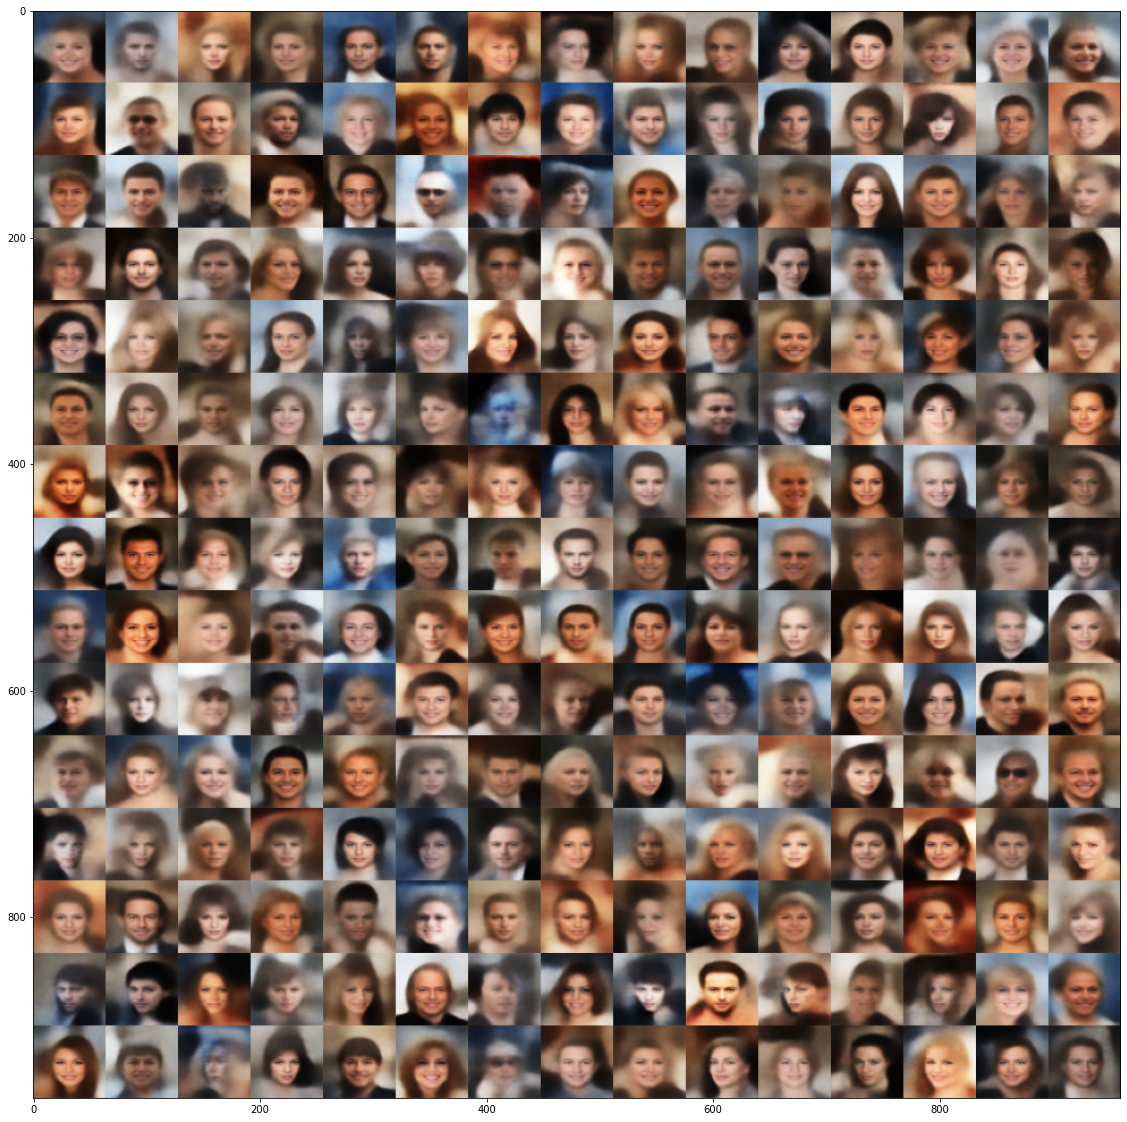

In [0]:
# display images generated from randomly sampled latent vector
import numpy as np
import matplotlib.pyplot as plt

n = 15
img_size = 64
figure = np.zeros((img_size * n, img_size * n, 3))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.normal(0, 1 ,size=latent_dim)])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, 3)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

       
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [0]:
encoder.save('beta_encoder_celebA_20epochs.h5')
decoder.save('beta_decoder_celebA_20epochs.h5')

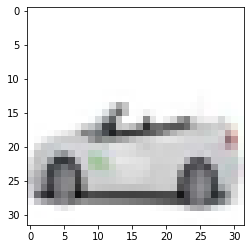

In [0]:
img = cifar[4500, :, :, :]
plt.imshow(img)
plt.show()

In [0]:
img = tf.reshape(img, (-1,32,32,3))
img_encode = encoder.predict(img)
img_decode = decoder.predict(img_encode)

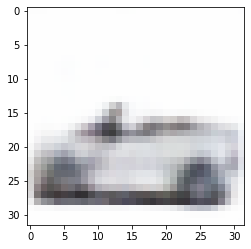

In [0]:
img_decode = tf.reshape(img_decode, (-1,32,32,3))
img_dec = img_decode[0, :, :, :]
plt.imshow(img_dec)
plt.show()

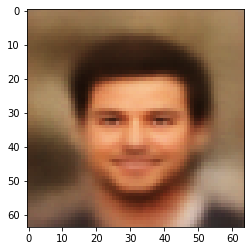

In [0]:
z_sample = np.array([np.random.normal(0, 1 ,size=latent_dim)])
img_decode = decoder.predict(z_sample)
img_decode = tf.reshape(img_decode, (-1,64,64,3))
img_dec = img_decode[0, :, :, :]
plt.imshow(img_dec)
plt.show()

## GAN

In [0]:
IMG_SHAPE = (32, 32, 3)
noise_dim = 128

### Blocs de base

In [0]:
def bn_relu_conv(tensor, filters, kernel_size, strides, use_bn = True):

  if use_bn:
    x = BatchNormalization()(tensor)
    x = ReLU()(x)
  else:
    x = ReLU()(tensor)
  
  x = Conv2D(filters=filters,
             kernel_size=kernel_size,
             strides=strides,
             padding='same',
             kernel_initializer='he_uniform',
             use_bias=False)(x)

  return x

def conv_block(tensor, filters, use_bn, sampling = None):

  x = bn_relu_conv(tensor,
                   filters,
                   kernel_size = 3,
                   strides = 1,
                   use_bn = use_bn)
  
  if sampling == 'up':
    x = UpSampling2D()(x)
    x = bn_relu_conv(x,
                     filters,
                     kernel_size = 3,
                     strides = 1,
                     use_bn = use_bn)
    
    shortcut = UpSampling2D()(tensor)
    shortcut = Conv2D(filters = filters,
                      kernel_size = 1,
                      strides = 1,
                      kernel_initializer='he_uniform')(shortcut)
    x = Add()([x, shortcut])

  elif sampling == 'down':
    x = bn_relu_conv(x,
                     filters,
                     kernel_size = 3,
                     strides = 1,
                     use_bn = use_bn)
    x = AveragePooling2D()(x)

    shortcut = Conv2D(filters = filters,
                      kernel_size = 1,
                      strides = 1,
                      kernel_initializer='he_uniform')(tensor)
    shortcut = AveragePooling2D()(shortcut)

    x = Add()([x, shortcut])

  elif sampling == None:
    x = bn_relu_conv(x,
                     filters,
                     kernel_size = 3,
                     strides = 1,
                     use_bn = use_bn)
    
    x = Add()([x, tensor])
  else:
    raise Exception('invalid sampling value')
  
  return x

### Critique

In [0]:
def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)

    x = conv_block(img_input,
                   filters = 128,
                   use_bn = False,
                   sampling = 'down')
    x = conv_block(x,
                   filters = 128,
                   use_bn = False,
                   sampling = 'down')
    x = conv_block(x,
                   filters = 128,
                   use_bn = False,
                   sampling = None)
    x = conv_block(x,
                   filters = 128,
                   use_bn = False,
                   sampling = None)
    
    x = ReLU()(x)
    x = AveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
re_lu_131 (ReLU)                (None, 32, 32, 3)    0           input_25[0][0]                   
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 32, 32, 128)  3456        re_lu_131[0][0]                  
__________________________________________________________________________________________________
re_lu_132 (ReLU)                (None, 32, 32, 128)  0           conv2d_145[0][0]                 
______________________________________________________________________________________

### Générateur

In [0]:
def get_generator_model():
    noise = Input(shape=(noise_dim,))

    x = Dense(4*4*128, use_bias=False)(noise)

    x = Reshape((4, 4, 128))(x)
    
    x = conv_block(x,
                   filters = 128,
                   use_bn = True,
                   sampling = 'up')
    x = conv_block(x,
                   filters = 128,
                   use_bn = True,
                   sampling = 'up')
    x = conv_block(x,
                   filters = 128,
                   use_bn = True,
                   sampling = 'up')
    
    x = Conv2D(filters = 3,
               kernel_size = 3,
               padding='same',
               kernel_initializer='he_uniform')(x)

    x = Activation('tanh')(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2048)         262144      input_29[0][0]                   
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 4, 4, 128)    0           dense_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 4, 4, 128)    512         reshape_6[0][0]                  
__________________________________________________________________________________________

### Custom Class

In [0]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight
        
            # Update the weights
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


#### Détails

##### Init

Ici, rien de particuliers, on définit les variables de notre classe.

```python
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
```

##### Compile

Comme l'on a deux réseaux qui s'entraînent de façon séparée, on a deux optimiseurs et deux fonctions de pertes. On doit donc modifier la méthode `.compile()`.
```python
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
```

##### Gradient penalty

La pénalité du gradient est un des points clé faisant que les GAN de Wasserstein s'entraînent de façon correcte sans *mode collapse*.


```python
    def gradient_penalty(self, batch_size, real_images, fake_images):
```
La pénalité du gradient se calcule sur une **observation interpolée**, ie une observation que l'on obtient en faisant une combinaison linéaire de $x$ et $\tilde{x}$.

$$\hat{x} := \tilde{x} + \varepsilon(x - \tilde{x})$$ 

Avec $\tilde{x} = G(z)$, $x$ une observation du minibatch,  et $\varepsilon \sim \mathcal{N}(0, 1)$.

```python
        # interpolation de l'image
        epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + epsilon * diff
```
Le but de la fonction `gradient_penalty` est alors de calculer la moyenne suivante.

$$\mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}}[(||\nabla_{\hat{x}}D(\hat{x})||_{2}-1)^{2}]$$

Rappelons tout d'abord que nous travaillons sur des minibatchs, ie calculer $\mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}}(-)$ revient donc à calculer l'estimation non biaisée correspondante sur le minibatch $M$ en cours, c'est à dire calculer la moyenne suivante.

$$\frac{1}{N}\sum_{x \in M} (||\nabla_{\hat{x}}D(\hat{x})||_{2}-1)^{2}$$

Donc, pour chaque observation $x$ du minibatch $M$ :
  1. on l'interpole en $\hat{x}$,
  2. on calcule le gradient $\nabla_{\hat{x}}D(\hat{x})$ par rapport à $\hat{x}$,
  3. On calcule la norme $L_{2}$, $||\nabla_{\hat{x}}D(\hat{x})||_{2}$,
  4. On fait la somme $\sum_{x \in M} (||\nabla_{\hat{x}}D(\hat{x})||_{2}-1)^{2}$,
  5. On divise.

Rappellons que pour un tenseur $T= (t_{i,j,k})_{i,j,k}$ sur 3 axes (ici une image), sa norme $L_{2}$ est définie de façon usuelle par la formule suivante. 

$$ ||T||_{2} := \sqrt{\sum_{i,j,k} t_{i,j,k}^{2} }$$

Pour calculer un gradient on utilise `with tf.GradientTape() as gp_tape:` et on lui dit quel variable surveiller avec `gp_tape.watch(interpolated)`.

```python
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calcul du gradient par rapport à l'image interpolée.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # Calcul de la norme du gradient
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
```

Fonction entière :

```python
    def gradient_penalty(self, batch_size, real_images, fake_images):
        # interpolation de l'image
        epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + epsilon * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calcul du gradient par rapport à l'image interpolée.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # Calcul de la norme du gradient
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
```

Pour l'instant, cette fonction n'est pas utilisée, elle est utilisée dans la section suivante.

##### Train step

Dans l'étape d'entraînement, on fait les choses suivantes.

Pour chaque minibatch, 

1. On entraîne le générateur et on calcule la perte associée.
2. On entraîne le critique et on calcule la perte associée.
3. On calcule la pénalité du gradient.
4. On multiplie cette pénalité par une contante.
5. On ajoute cette pénalité à la perte du critique.
6. On retourne ces métriques dans un dictionnaire.

Rappelons que les pertes pour le critique $D$, $\mathcal{L}_{D}^{WGAN}$, et le générateur $G$, $\mathcal{L}_{G}^{WGAN}$, on les formules suivantes.

$$\begin{aligned}
\mathcal{L}_{D}^{WGAN} :=  & \, \mathbb{E}_{z  \sim p(z)}[D(G(z))] - \mathbb{E}_{x  \sim \mathbb{P}_{data}}[D(x)] \\
\mathcal{L}_{G}^{WGAN} := & \, -\mathbb{E}_{z  \sim p(z)}[D(G(z))]
\end{aligned}$$

Un fois la pénalité de gradient ajoutée, on obtient les formules suivantes.

$$\begin{aligned}
\mathcal{L}_{D}^{WGAN\_GP} :=  & \, \mathcal{L}_{D}^{WGAN} + \lambda \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}}[(||\nabla_{\hat{x}}D(\hat{x})||_{2}-1)^{2}] \\
\mathcal{L}_{G}^{WGAN\_GP} := & \, \mathcal{L}_{G}^{WGAN} = - \mathbb{E}_{z  \sim p(z)}[D(G(z))]
\end{aligned}$$

Avec $\hat{x} := \tilde{x} + \varepsilon(x - \tilde{x})$, avec $\tilde{x} = G(z)$, et $\varepsilon \sim \mathcal{N}(0, 1)$. 

**Détaillons étapes par étapes**.

```python
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Taille du batch
        batch_size = tf.shape(real_images)[0]
```

On entraîne d'abord le critique, l'article d'origine suggère d'entraîner le critique plus longtemps que le générateur. Ici, on l'entraînera 3 étapes pour une étape de générateur.

```python
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
```
On prend un vecteur latent $z \sim p(z)$ de dimension (batch_size, latent_dim)

```python
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
```
On génère de fausses images à partir du générateur, $\hat{x} = G(z)$.
```python
                fake_logits = self.discriminator(fake_images, training=True)
```
Le critique donne un score aux fausses images, $D(G(z))$.
```python              
                real_logits = self.discriminator(real_images, training=True)
```
Le critique donne un score aux vraies images, $D(x)$.
```python
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
```
On calcule la perte du critique entre les fausses et les vraies images, $\mathcal{L}_{D}^{WGAN}$.
```python
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
```
Calcul de la pénalité du gradient $\mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}}[(||\nabla_{\hat{x}}D(\hat{x})||_{2}-1)^{2}]$.
```python
                d_loss = d_cost + gp * self.gp_weight
```
Ajout de la pénalité du gradient à la perte du critique, $\mathcal{L}_{D}^{WGAN\_GP}$.
```python
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )
```
Calcul du gradient pour la perte du critique et mise a jour des poids du critique, $\vartheta \leftarrow \vartheta -\eta\nabla_{\vartheta}\mathcal{L}_{D}^{WGAN\_GP}$.

On passe alors maintenant à l'entraînement du générateur, qui se déroule de la même façon.

```python
        # on prend un vecteur latent
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # On génère de fausses images
            generated_images = self.generator(random_latent_vectors, training=True)
            # On obtient le score du critique sur les fausses images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # On calcule la perte du générateur
            g_loss = self.g_loss_fn(gen_img_logits)

        # On prend le gradient de la perte du générateur
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)

        # Mise à jour des poids du générateur
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
```

On renvoit les nouvelles métriques sous la forme d'un dictionaire.
```python
        return {"d_loss": d_loss, "g_loss": g_loss}
```

On doit maintenant définir les fonctions de pertes que l'on va calculer. On rappelle que l'on a les formules suivantes.

$$\begin{aligned}
\mathcal{L}_{D}^{WGAN} :=  & \, \mathbb{E}_{z  \sim p(z)}[D(G(z))] - \mathbb{E}_{x  \sim \mathbb{P}_{data}}[D(x)] \\
\mathcal{L}_{G}^{WGAN} := & \, -\mathbb{E}_{z  \sim p(z)}[D(G(z))]
\end{aligned}$$

$D(G(z))$ étant défini comme `fake_images` et $D(x)$ comme `real_images` plus haut dans la fonction `train_step`, il reste juste à prendre la moyenne. La pénalité du gradient étant directement réjoutée dans `train_step`.

```python
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)
```

In [0]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

In [0]:
# Optimizer for both the networks
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002,
                                            beta_1=0.5,
                                            beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002,
                                                beta_1=0.5,
                                                beta_2=0.9)

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cifar10 = keras.datasets.cifar10
(train_images, _), (test_images, _) = cifar10.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# we will reshape each sample to (28, 28, 1) and normalize the pixel values in [-1, 1].
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

170500096/170498071 [==============================] - 6s 0us/step
Number of examples: 50000
Shape of the images in the dataset: (32, 32, 3)


In [0]:
# Epochs to train
epochs = 10

# Start training
wgan.fit(train_images,
         batch_size=64,
         epochs=epochs)

Epoch 1/10
782/782 [==============================] - 447s 572ms/step - d_loss: -1.3801 - g_loss: 3.5764
Epoch 2/10
782/782 [==============================] - 448s 573ms/step - d_loss: -1.3828 - g_loss: 10.7120
Epoch 3/10
782/782 [==============================] - 448s 573ms/step - d_loss: -1.4531 - g_loss: 7.7392
Epoch 4/10
782/782 [==============================] - 448s 573ms/step - d_loss: -1.4142 - g_loss: 12.2459
Epoch 5/10
782/782 [==============================] - 448s 573ms/step - d_loss: -1.3634 - g_loss: 9.3231
Epoch 6/10
782/782 [==============================] - 449s 574ms/step - d_loss: -1.3804 - g_loss: 6.6700
Epoch 7/10
782/782 [==============================] - 449s 574ms/step - d_loss: -1.3052 - g_loss: 6.9166
Epoch 8/10
782/782 [==============================] - 449s 574ms/step - d_loss: -1.3354 - g_loss: 7.5646
Epoch 9/10
782/782 [==============================] - 449s 574ms/step - d_loss: -1.3280 - g_loss: 7.2135
Epoch 10/10
782/782 [==============================] 

In [0]:
g_model.save('gen_cifar_30epochs.h5')
d_model.save('critic_cifar_30epochs.h5')

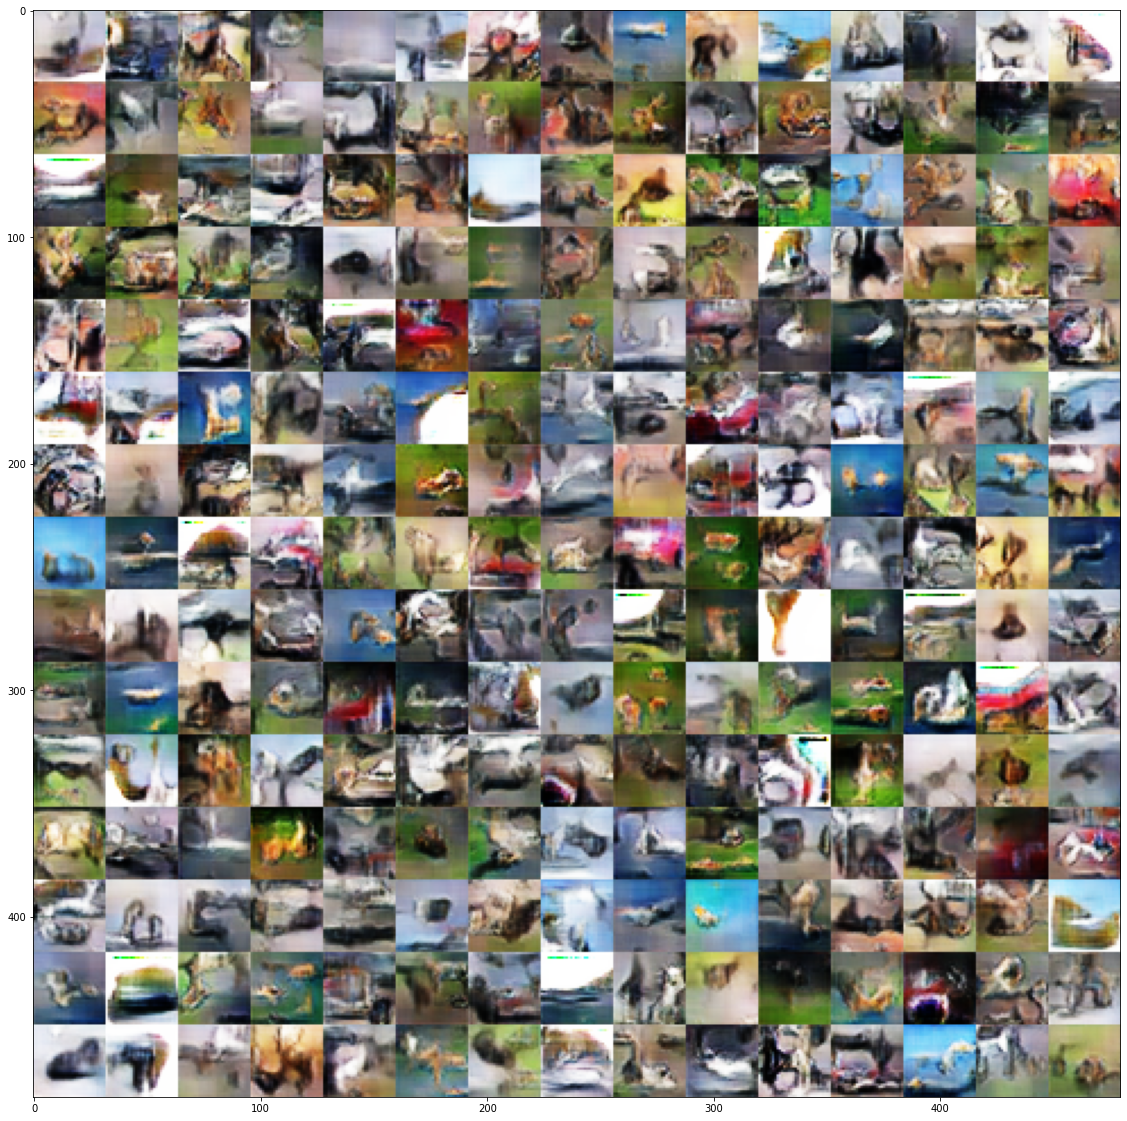

In [0]:
# display images generated from randomly sampled latent vector
import numpy as np
import matplotlib.pyplot as plt

n = 15
img_size = 32
figure = np.zeros((img_size * n, img_size * n, 3))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.normal(0, 1 ,size=noise_dim)])
        x_decoded = g_model.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, 3)
        img = (127.5*img +127.5)/255
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

       
plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
plt.show()

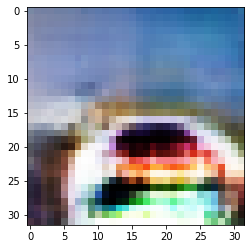

In [0]:
z_sample = np.array([np.random.normal(0, 1 ,size=noise_dim)])
img_decode = g_model.predict(z_sample)
img_decode = tf.reshape(img_decode, (-1,32,32,3))
img_decode = (127.5*img_decode +127.5)/255
img_dec = img_decode[0, :, :, :]
plt.imshow(img_dec)
plt.show()